In [360]:
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score ,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import set_config

In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

set_config(display="diagram")

##### Estamos utilizando um dataset para discriminação de vozes masculinas e femininas. https://www.kaggle.com/datasets/primaryobjects/voicegender

##### Este é um dataset para classificação.

# Importando dataset

In [301]:
df = pd .read_csv('../input/voice.csv')

##### É importante conhecer o formato dos dados que estamos lidando. O dataset possui 3168 amostras com 20 features para a classificação e uma coluna de labels

In [302]:
Nsamples, Nfeatures = df.shape
print(f'Nsamples:{Nsamples}\nNfeatures: {Nfeatures}')
df.head()

Nsamples:3168
Nfeatures: 21


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Enconding dos Labels

##### As classes estão definidas como 'male' e 'female', entretando para o treinamento precisamos necessitamos que esse valores sejam variáveis inteiras discretas. Para isso estruturamos um enconding das classes onde a classa 'male' se torna 0 e a classe 'female' 1

In [303]:
print(df.label.value_counts())
dict = {'male':0,'female':1}
df.label.replace(dict,inplace = True)
df.head()

male      1584
female    1584
Name: label, dtype: int64


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0


##### Como o número de amostras entre as classes são iguais não será utilizar técnicas de balanceamento das classes como SMOTE ou Bootstrapping na validação.

## Correlação de Features 

<AxesSubplot:>

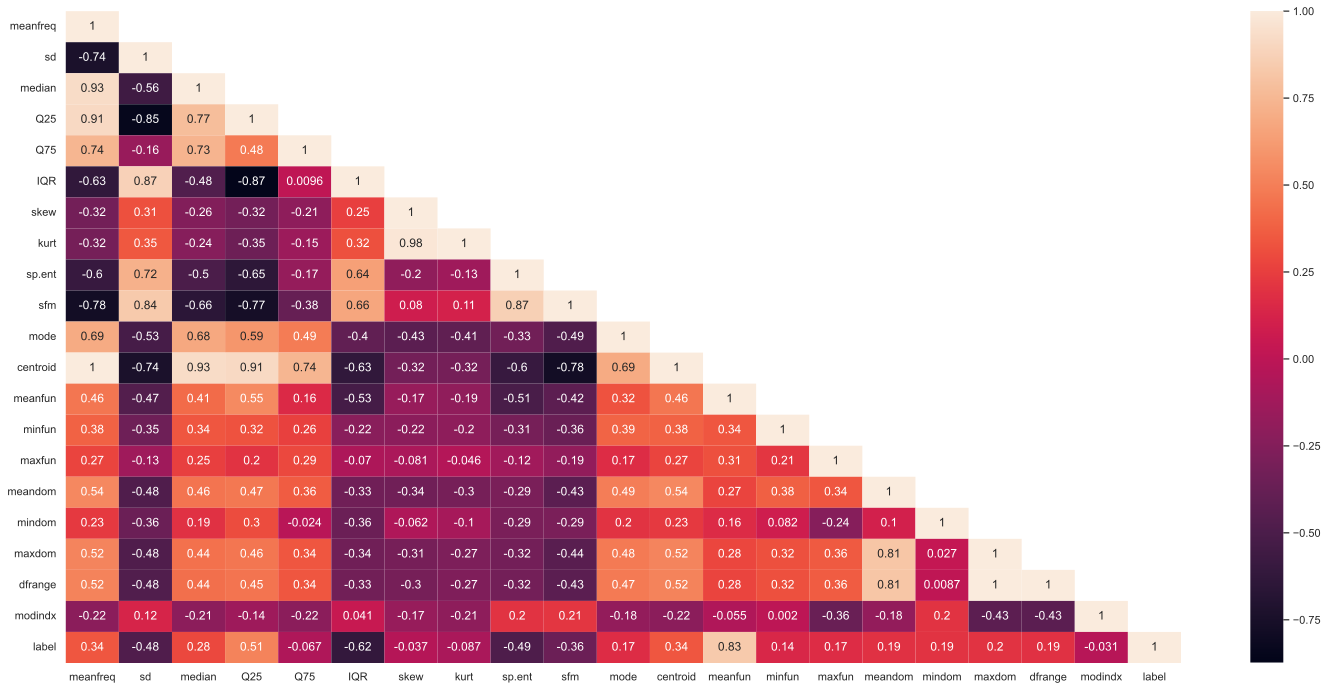

In [304]:
sns.set(style='whitegrid',color_codes=True)
cor_mat= df.corr(method='pearson')
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False ## triangular inferior
fig=plt.gcf()
fig.set_size_inches(25,12)
sns.heatmap(data=cor_mat,mask=mask,annot=True,cbar=True)

##### É possível observar que algumas das features são linearmente correlacionadas. Isso fornece índicios que é possível realizar uma redução de dimensionalidade para diminuir a redundância de features.

Temos como hipótese que as seguintes features são equivalentes:
- MeanFreq $\approx$ Centroid
- dfrange $\approx$ maxdom

##### É interessante visualizar algumas das caracteristicas do dataset

In [305]:
def plot_male_female(feature):
    sns.catplot(data=df,y=feature, x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(10,10)

##### Homens tendem a ter uma frequência média da voz mais baixa, i.e, grave.

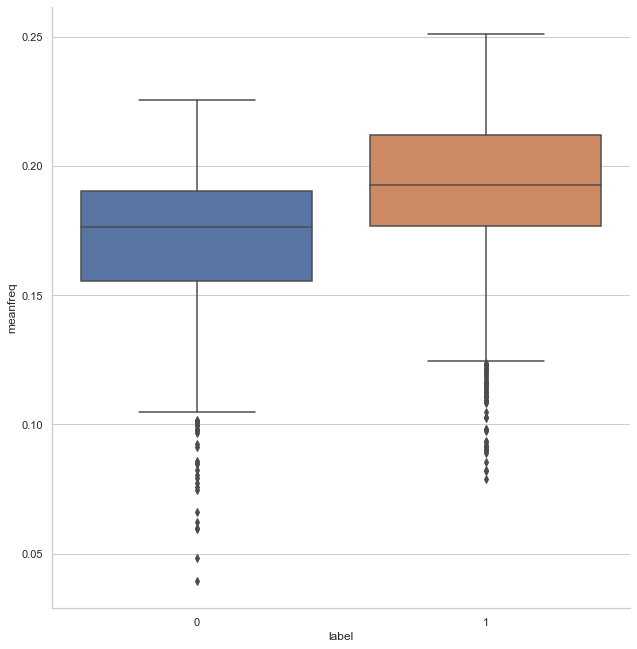

In [ ]:
plot_male_female('meanfreq')

## Checando por valores de feature nulos 

##### Não podemos alimentar os modelos com valores nulos, portanto precisamos validar se alguma das amostras do dataset apresenta features nulas.

In [ ]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

##### Nenhuma das features possui valores nulos, portanto não cabe nenhum tratamento.
##### Porém, se fosse o caso poderiamos utilizar um [SimpleInputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) para substituir os valores ou simplesmente descartá-los

## Separação Amostras e Labels

In [ ]:
X, y = df.loc[:, df.columns!='label'], df.loc[:, 'label']
X.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


# Classificação

##### O método de validação cruzada utilizado será o K-Fold estratificado onde cada fold possui um número de amostras igual a distribuição dos dados na matrix original. Como apresentado acima, a distribuição das classes é uniforme, portanto o treino será balanceado. O objeto que performa essa distribuição será o mesmo para todos os classificadores testados.

##### Para todas os modelos utilizaremos uma padronização das amostras através do Stan

##### Utilizaremos as métricas de acurácia e f1 score para avaliar os modelos.

##### Como observamos que algumas features possuem alta correlação entre si, utilizaremos os redutores de dimensionalidade PCA e SVD para testar essa hipótese. Será variado de 1 até N_features-1, neste caso, 19.

##### Utilizaremos a estrutura de pipelines em GridSeach para testar todas as combinações de redutores de dimensionalidade e número de features.

In [201]:
cv = StratifiedKFold(n_splits=5,random_state=9 ,shuffle=True)
scores = {'acc' :make_scorer(accuracy_score), 
        'f1':make_scorer(f1_score)}
N_FEATURES_OPTIONS = list(range(1, X.shape[1]))
reducer_labels = ["PCA", "SVD"]
param_grid = [
    {
        "reduce_dim": [PCA(n_components=10), TruncatedSVD()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    }
]

## LDA

##### O primeiro classificador testado será o LDA, se o problema for uma classificação linear simples é provável que o LDA perfome bem.

In [202]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", LinearDiscriminantAnalysis()),
    ]
)
grid_LDA = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

##### Abaixo podemos ver a estrutura utilizada para esse modelo. Primeiro a padronização dos dados, seguida da redução de dimensionalidade por PCA ou SVD passada para 'passtrough' e, por fim, o LDA.

In [203]:
grid_LDA.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearDiscriminantAnalysis())]),
             param_grid=[{'reduce_dim': [PCA(n_components=12), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

##### Na tabela cv_results_ temos os resultados das iterações do GridSearch. Apesar de PCA estar descrito com n_components=12 o valor verdadeiro passado é param_reduce_dim__n_components

In [127]:
results_LDA = pd.DataFrame(grid_LDA.cv_results_)
results_LDA[['params', 'param_reduce_dim__n_components','mean_train_acc', 'mean_train_f1','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_train_acc,mean_train_f1,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",1,0.670928,0.684288,0.671719,0.684585
1,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",2,0.818024,0.811106,0.815972,0.809030
2,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",3,0.815972,0.809041,0.811868,0.805006
3,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",4,0.839883,0.823714,0.840595,0.823917
4,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",5,0.886442,0.879948,0.884782,0.877982
5,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",6,0.889599,0.883464,0.888253,0.882182
6,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",7,0.923058,0.920658,0.923295,0.920722
7,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",8,0.922112,0.919822,0.920457,0.918040
8,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",9,0.966383,0.965986,0.966857,0.966468
9,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",10,0.966383,0.965988,0.966857,0.966453


##### Abaixo temos o um gráfico representando as acurácias da redução de dimensionalidade por PCA e SVD variando o número de features.

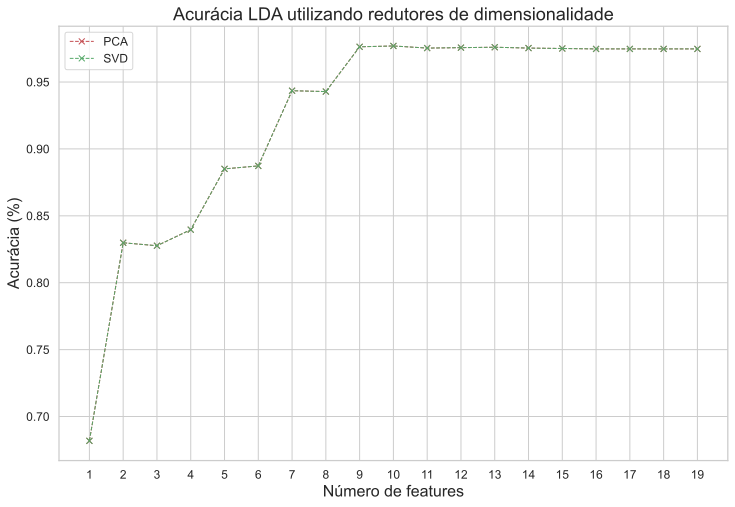

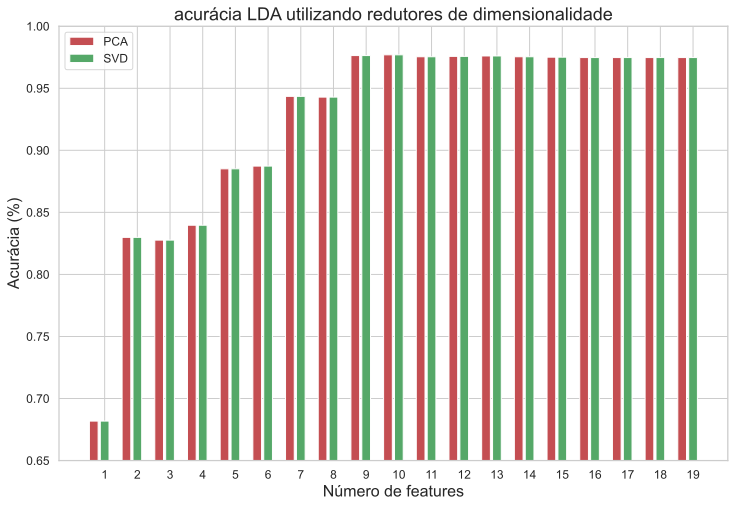

In [243]:
# mean_scores = np.array(results_LDA["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

plt.figure(figsize=(12,8))
COLORS = ["Purple", "g"]

## PLOT 
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    # plt.plot(bar_offsets+i, reducer_scores, color=COLORS[i], linestyle='dashed', linewidth=1)
    plt.plot(N_FEATURES_OPTIONS, reducer_scores, label=label, color=COLORS[i], linestyle='dashed', linewidth=1, marker='x')
    
plt.title("Acurácia LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.ylabel("Acurácia (%)")
plt.xticks(N_FEATURES_OPTIONS)
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(12,8))
bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets+i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### Estas representações gráficas nos mostram que a diferença entre PCA e SVD não são significativas. Analisando a tabela cv_results_ confirmamos essa hipótese.

##### Podemos notar também que somente há uma queda significativa da acurácia para um número de features menor que 9. Isto é, muitas dessas caracteristica ou apresentavam alta correlação ou eram irrelevantes para o problema. 

## SVM

##### O segundo classificador que utilizaremos será a SVM.

In [245]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", SVC(kernel='linear', C=10, gamma='scale')),
    ]
)

grid_SVC = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

##### A linha do modelo segue a mesma, mas agora o classificador é a SVM

In [246]:
grid_SVC.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        SVC(C=10, kernel='linear'))]),
             param_grid=[{'reduce_dim': [PCA(n_components=10), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [250]:
results_SVC = pd.DataFrame(grid_SVC.cv_results_)
results_SVC[['params', 'param_reduce_dim__n_components','mean_train_acc', 'mean_train_f1','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_train_acc,mean_train_f1,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",1,0.681187,0.687592,0.681820,0.687801
1,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",2,0.830650,0.813097,0.829862,0.812058
2,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",3,0.830177,0.812440,0.827653,0.809443
3,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",4,0.842093,0.821894,0.839649,0.819009
4,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",5,0.887626,0.883205,0.885098,0.880680
5,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",6,0.888810,0.884462,0.887308,0.882512
6,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",7,0.942945,0.942602,0.943501,0.943070
7,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",8,0.944839,0.944435,0.942870,0.942502
8,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",9,0.976405,0.976387,0.976325,0.976298
9,"{'reduce_dim': PCA(n_components=10), 'reduce_d...",10,0.976484,0.976461,0.976957,0.976939


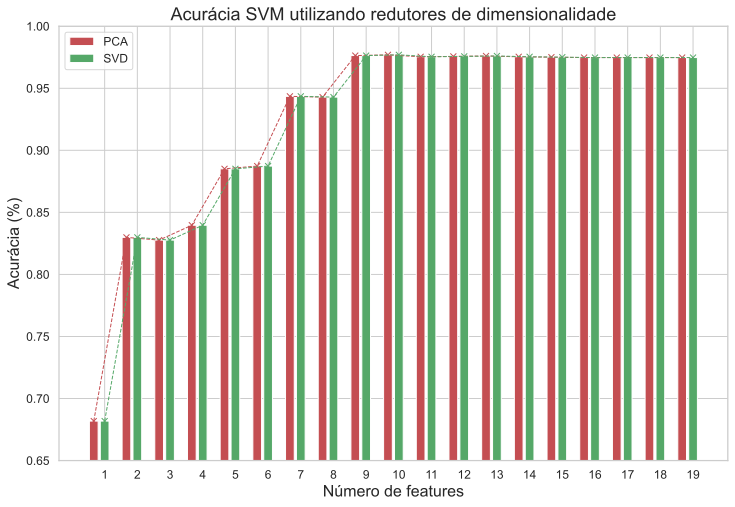

In [254]:
mean_scores = np.array(results_SVC["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

plt.figure(figsize=(12,8))
COLORS = ["Purple", "g"]

## PLOT
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.plot(bar_offsets + i, reducer_scores, color=COLORS[i], marker='x', linestyle='dashed', linewidth=1)
    
## BAR 
bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### A classificação por SVM obteve resultado similar ao LDA, com uma diferença pouco significativa.

## Random Forest

##### Em seguida testaremos o Random Forest.

In [255]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", RandomForestClassifier()),
    ]
)
grid_RandomForest = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

In [256]:
grid_RandomForest.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [PCA(n_components=17), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [257]:
results_RandomForest = pd.DataFrame(grid_RandomForest.cv_results_)
results_RandomForest[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",1,0.651517,0.651013
1,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",2,0.829867,0.822305
2,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",3,0.850387,0.843774
3,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",4,0.879426,0.875244
4,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",5,0.933716,0.932212
5,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",6,0.945078,0.944182
6,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",7,0.957708,0.957408
7,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",8,0.959603,0.959357
8,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",9,0.972227,0.972128
9,"{'reduce_dim': PCA(n_components=17), 'reduce_d...",10,0.969385,0.969210


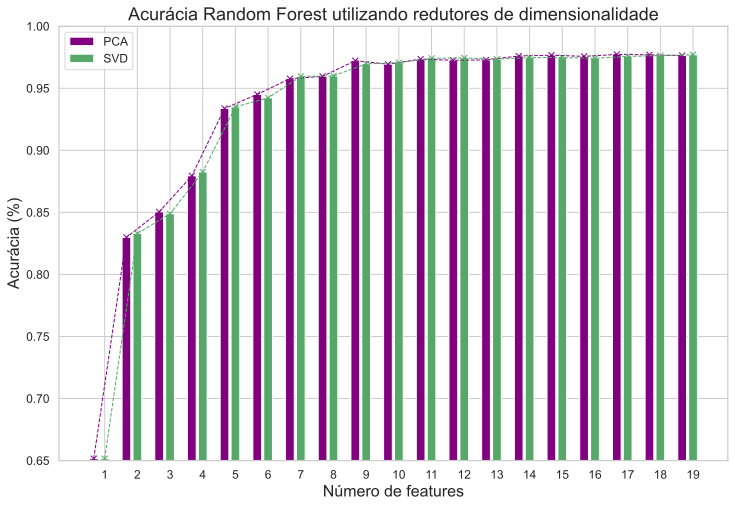

In [258]:
mean_scores = np.array(results_RandomForest["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

plt.figure(figsize=(12,8))
COLORS = ["Purple", "g"]

## PLOT
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.plot(bar_offsets + i, reducer_scores, color=COLORS[i], marker='x', linestyle='dashed', linewidth=1)
    
## BAR 
bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### Podemos observar resultados de acurácia virtualmente idênticos aos classificadores anteriores.

##### Isso nós leva a concluir que este é um problema simples e fortemente linear, sendo um LDA suficiente para solucioná-lo

In [274]:
# accs=[]
# acc_folds_train = []
# acc_folds_test = []
# for train_index, test_index in cv.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train, y_train)
#     X_test = scaler.transform(X_test)

#     ANN = SVC().fit(X_train,y_train)

#     acc_folds_train.append(accuracy_score(y_train, ANN.predict(X_train)))
#     acc_folds_test.append(accuracy_score(y_test, ANN.predict(X_test)))
# accs.append([acc_folds_train, acc_folds_test])

## NN

##### Já observamos que este problema pode ser resolvido por classificadores simples, porém como exercício aplicaremos uma MLP.

In [ ]:
accs = []
acc_folds_train = []
acc_folds_test = []
for i in range(1,21):
    for j in range(0,21):
        print(f'iteration {i}.{j}...')
        acc_folds_train = []
        acc_folds_test = []
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train, y_train)
            X_test = scaler.transform(X_test)
            if(j>0):
                ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,j), max_iter=2000).fit(X_train,y_train)
            else:
                ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i), max_iter=2000).fit(X_train,y_train)
            
            acc_folds_train.append(accuracy_score(y_train, ANN.predict(X_train)))
            acc_folds_test.append(accuracy_score(y_test, ANN.predict(X_test)))
        accs.append([acc_folds_train, acc_folds_test])

In [311]:
accs_mlp = [np.mean(acc,axis=1) for acc in accs]
acc_train = []
acc_test = []
for i in range(len(accs_mlp)):
    acc_train.append(accs_mlp[i][0])
    acc_test.append(accs_mlp[i][1])

In [460]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(labels=[i for i in range(data.shape[1])])
    ax.set_yticklabels(labels=[i for i in range(1,data.shape[0]+1)])

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    ax.grid(which="minor", color="w", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


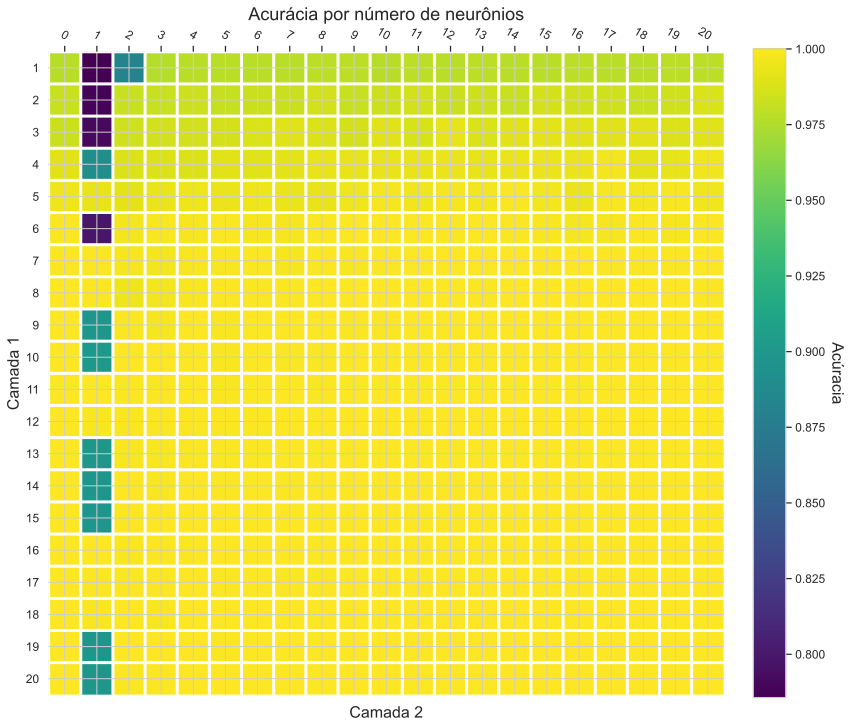

In [485]:
import seaborn as sns

data = np.array(acc_train).reshape(20,21)
fig, ax = plt.subplots()

im, cbar = heatmap(data, range(1,21), range(0,21), ax=ax,
                   cbar_kw={"fraction":0.044, "pad":0.04},cmap="viridis", cbarlabel="Acúracia")

plt.ylabel('Camada 1')
plt.xlabel('Camada 2')
plt.title('Acurácia por número de neurônios')
fig.tight_layout()
plt.show()

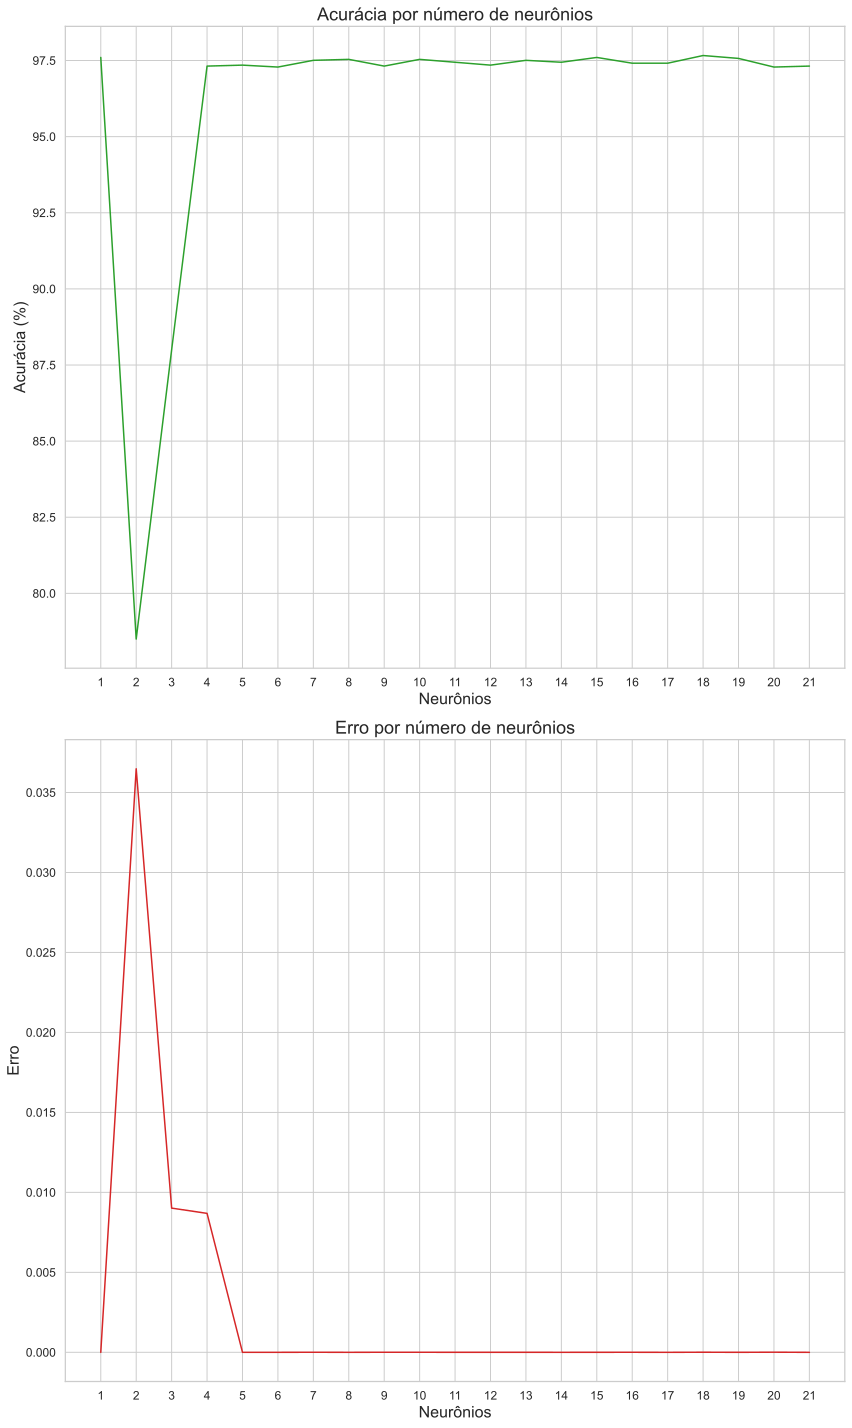

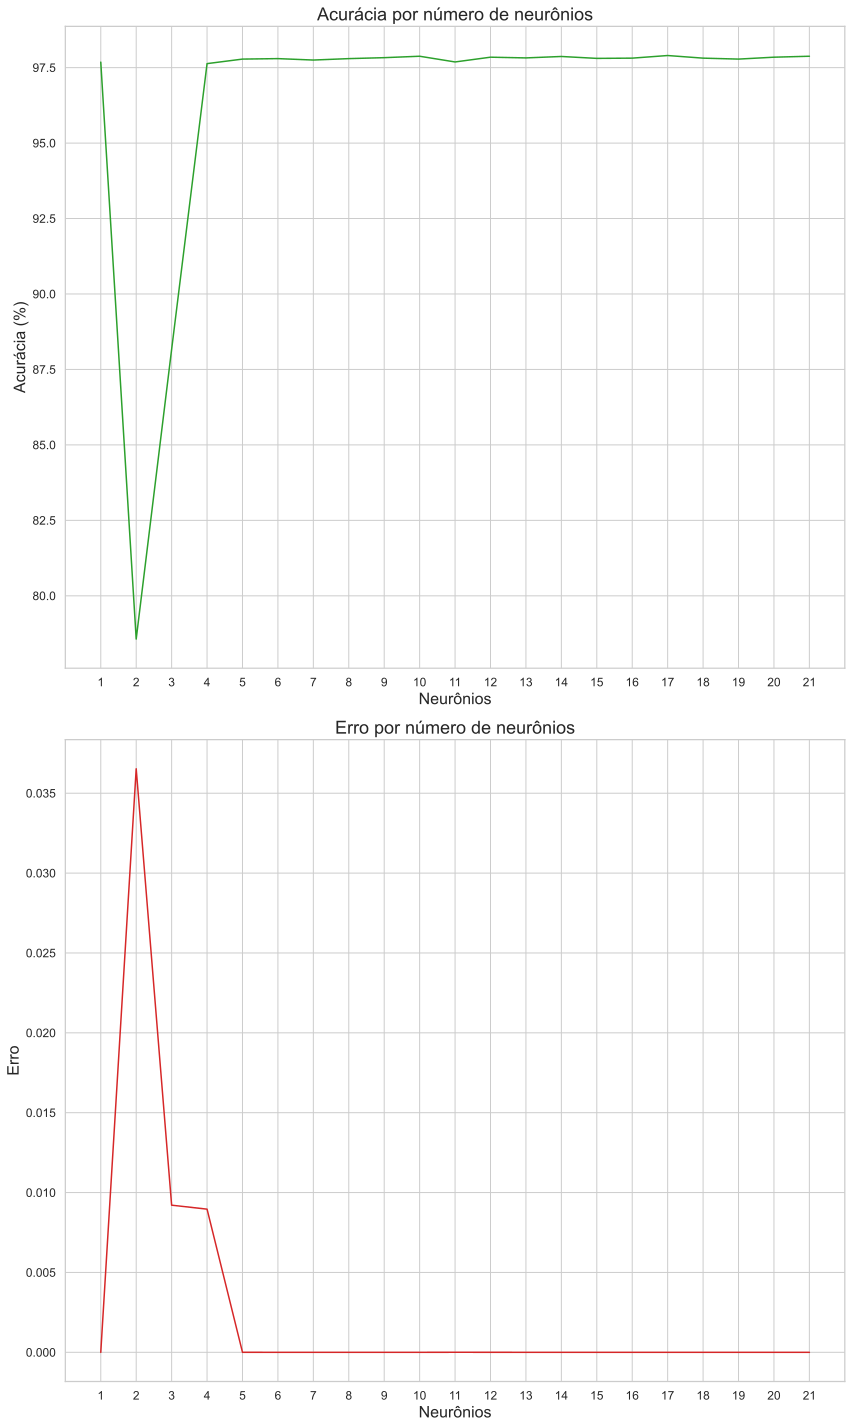

In [480]:
def accs_err_graph(acc):
    err_acc = [0]
    for i in range(1, len(acc)):
        err_acc.append((acc[i]-acc[i-1])**2)

    # x = np.linspace(1, len(acc), num=len(acc))
    x = [f'{i}' for i in range(1,acc.shape[0]+1)]
    fig, axs = plt.subplots(2)

    axs[0].plot(x, acc*100, 'tab:green')
    axs[0].set_title("Acurácia por número de neurônios")
    axs[0].set(xlabel='Neurônios',ylabel="Acurácia (%)")

    axs[1].plot(x,  np.array(err_acc), 'tab:red')
    axs[1].set_title("Erro por número de neurônios")
    axs[1].set(xlabel='Neurônios',ylabel="Erro")

    for ax in axs:
        ax.grid(True)

    fig.tight_layout()

params = {'figure.figsize': [12, 20], 
          'axes.labelsize': 16,
          'axes.titlesize':18, 
          'font.size': 12,
          'legend.fontsize': 12, 
          'xtick.labelsize': 12, 
          'ytick.labelsize': 12
         }
plt.rcParams.update(params)

accs_err_graph(np.array(acc_test).reshape(20,21)[0]) ## PRIMEIRA CAMADA
accs_err_graph(np.array(acc_train).reshape(20,21)[0])

## IDEIAS PARA APRIMORAMENTO

- Ver quais features são menos relevantes, i.e, tem mais correlação entre si. 
- Levantar hipóteses sobre as features
- Descrição das Features.
- SVM fine tuning
- Comparar os resultados
- [Curvas de aprendizado](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)
- MUDAR O GRÁFICO DOS RESULTADOS PARA SCATTER LIGADO. INTRODUZIR AS ACCURÁCIAS DE TREINO